# Loading Libraries

In [1]:
#data management tools
import pandas as pd
import numpy as np

from matplotlib import pyplot

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

import seaborn as sb
import datetime

# #Vectorization and Tokenizing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn import utils
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import mean_absolute_error

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

# #DNN Modules
# import torch
import tensorflow as tf
from tensorflow import keras
from keras.metrics import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# from tensorflow.keras.layers import InputLayer
# from tensorflow.keras import losses
# from tensorflow.keras.regularizers import L2
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.layers import TextVectorization

# #Models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC  

# #Metrics and Testing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import multiprocessing
cores = multiprocessing.cpu_count()
from itertools import chain

import xlwings as xw

2023-04-25 19:55:31.900537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataloading and Preprocessing

In [2]:
#My MacBook
df1 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/logon.csv')
df2 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/device.csv')
df3 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/email.csv')
df4 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/file.csv')
df5 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/http.csv')
ans = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/answers/answers.csv')
ldap = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/ldap/2009-12.csv')
df6 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/psychometric.csv')

In [3]:
df3['activity'] = "email"
df4['activity'] = "file"
df5['activity'] = "http"

In [4]:
START = datetime.date(2010,10,1)
END = datetime.date(2010,10,31)

In [5]:
df_merged = pd.concat([df1, df2, df3, df4, df5])
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged['day_date'] = pd.to_datetime(df_merged['date']).dt.date

In [6]:
df_time_range = df_merged[((df_merged['day_date'] >= START) & (df_merged['day_date'] <= END))]

In [7]:
df_time_range['label'] = 'normal'
df_time_range.loc[df_time_range['id'].isin(ans['id']),['label']] = 'abnormal'

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_72139/1036657486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_range['label'] = 'normal'


In [8]:
#userEvents = df_time_range.loc[(df_time_range['user'] == 'IJM0776')]
userEvents = df_time_range

In [9]:
userEvents['activityMinute'] = userEvents['date'].apply(lambda s: (s - s.replace(hour=0, minute=0, second=0, microsecond=0)).seconds)
userEvents['activityMinute'] = userEvents['activityMinute'].apply(lambda s: (s/60))

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_72139/1096339616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['activityMinute'] = userEvents['date'].apply(lambda s: (s - s.replace(hour=0, minute=0, second=0, microsecond=0)).seconds)
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_72139/1096339616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['activityMinute'] = userEvents['activityMinute'].apply(lambda s: (s/60))


# NLP

In [10]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
def prepare_text(pretext):

    # tokenize mission.
    tokens = word_tokenize(pretext, language="english", preserve_line=True)

    # # # Parts of speech (POS) tag tokens.
    # token_tag = pos_tag(tokens)
    
    # # # Only include some of the POS tags.
    # include_tags = ['VBN', 'VBD', 'JJ', 'JJS', 'JJR', 'CD', 'NN', 'NNS', 'NNP', 'NNPS']
    # filtered_tokens = (tok for tok, tag in token_tag if tag in include_tags)    
    
    # # #stem words.
    # stemmed_tokens = (lancaster.stem(tok) for tok in filtered_tokens)

    # # #lemm words.
    # lemmed_words = (lemmatizer.lemmatize(tok) for tok in stemmed_tokens)

    # lower_words = [str.lower(tok) for tok in lemmed_words]

    joined = ", ".join(tokens)

    return(joined)

#ps = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
userEvents['content'].fillna('', inplace=True)
userEvents['tokenized'] = userEvents['content'].apply(prepare_text)

nltk.download('stopwords')
stops = set(stopwords.words('english'))
tfidfvectorizer = TfidfVectorizer(stop_words='english', analyzer='word' )

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_72139/3616404602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['content'].fillna('', inplace=True)
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_72139/3616404602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['tokenized'] = userEvents['content'].apply(prepare_text)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
tfidf_list = tfidfvectorizer.fit_transform(userEvents['tokenized'])
userEvents['tfidf_mean'] = ((tfidf_list.sum(axis=1).transpose()) / (tfidf_list.getnnz(axis=1))).transpose()

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_72139/480841705.py:2: RuntimeWarning: invalid value encountered in divide
  userEvents['tfidf_mean'] = ((tfidf_list.sum(axis=1).transpose()) / (tfidf_list.getnnz(axis=1))).transpose()
/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_72139/480841705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userEvents['tfidf_mean'] = ((tfidf_list.sum(axis=1).transpose()) / (tfidf_list.getnnz(axis=1))).transpose()


# INDIVIDUAL ANALYSIS

In [13]:
dates = userEvents['day_date']
dates = dates.unique()

In [14]:
INTERVAL=60
dateActivity = []
for d in dates:
    dayEvents = userEvents.loc[(userEvents['day_date'] == d)]
    users = dayEvents['user']
    users = users.unique()
    for u in users:
        label = 0
        dailyActivityMatrix = []
        userdf = dayEvents.loc[(dayEvents['user'] == u)]
        for i in range(0, 1440, INTERVAL):
            bin_Events = userdf.loc[(userdf['activityMinute'] >= i ) & (userdf['activityMinute'] < (i + INTERVAL))]
            connect_count = bin_Events[bin_Events['activity'] == 'Connect'].shape[0]
            disconnect_count = bin_Events[bin_Events['activity'] == 'Disconnect'].shape[0]
            login_count = bin_Events[bin_Events['activity'] == 'Logon'].shape[0]
            logout_count = bin_Events[bin_Events['activity'] == 'Logoff'].shape[0]
            email_count = bin_Events[bin_Events['activity'] == 'email'].shape[0]
            file_count = bin_Events[bin_Events['activity'] == 'file'].shape[0]
            http_count = bin_Events[bin_Events['activity'] == 'http'].shape[0]
            intervalList = [connect_count, login_count, logout_count, email_count, file_count, http_count, disconnect_count]
            dailyActivityMatrix.append(intervalList)
            if (bin_Events[(bin_Events['label'] == 'abnormal')].shape[0] > 0): label = 1
        text_df = userdf.loc[(userdf['activity'] == 'http')]
        tfidf_mean = text_df['tfidf_mean'].mean()
        dateActivity.append([d, u, dailyActivityMatrix, tfidf_mean, label])

In [50]:
final = pd.DataFrame(dateActivity, columns=['date', 'user', 'dailyActivityMatrix', 'tfidf_mean', 'label'])
final['dailyActivityMatrix'] = final['dailyActivityMatrix'].apply(lambda y: (list(chain.from_iterable(y))))
df_temp = pd.DataFrame(final['dailyActivityMatrix'].tolist())
df_final = final.join(df_temp) 

In [51]:
users = df_final['user']
users = users.unique()

DAYS_PAST = 7
indPastActivity = pd.DataFrame()
for u in users:
    userevents = final.loc[(final['user'] == u)]
    vector_activity = userevents.loc[:, ['dailyActivityMatrix']]
    vector_past_activity = vector_activity.shift(DAYS_PAST)
    vector_past_activity = vector_past_activity.rename(columns={'dailyActivityMatrix':'dailyActivityMatrixPast'})
    
    vector_text = userevents.loc[:, ['tfidf_mean']]
    vector_past_text = vector_text.shift(DAYS_PAST)
    vector_past_text = vector_past_text.rename(columns={'tfidf_mean':'tfidf_mean_past'})
    
    events = userevents.filter(['user', 'date'])
    events = events.join(vector_past_activity)
    events = events.join(vector_past_text)
    indPastActivity = pd.concat([indPastActivity, events])

In [52]:
df_final = pd.merge(df_final, indPastActivity, on=['user', 'date'], how='left')

# GROUP ANALYSIS

In [53]:
ldap = ldap.rename(columns={'user_id': 'user'})
userEventsDept = pd.merge(userEvents, ldap, on='user', how='left')

In [54]:
dates = userEvents['day_date']
dates = dates.unique()

In [55]:
deptActivity = []
for d in dates:
    DayEvents = userEventsDept.loc[(userEventsDept['day_date'] == d)]
    depts = DayEvents['department']
    depts = depts.unique()
    for p in depts:
        dailyDeptActivityMatrix = []
        deptdf = DayEvents.loc[(DayEvents['department'] == p)]
        for i in range(0, 1440, INTERVAL):
            bin_Events = deptdf.loc[(deptdf['activityMinute'] >= i ) & (deptdf['activityMinute'] < (i + INTERVAL))]
            size = bin_Events.size
            if (bin_Events.size > 0):
                connect_count_mean = ((bin_Events[bin_Events['activity'] == 'Connect'].shape[0]) / size)
                disconnect_count_mean = (bin_Events[bin_Events['activity'] == 'Disconnect'].shape[0] / size)
                login_count_mean = (bin_Events[bin_Events['activity'] == 'Logon'].shape[0] / size)
                logout_count_mean = (bin_Events[bin_Events['activity'] == 'Logoff'].shape[0] / size)
                email_count_mean = (bin_Events[bin_Events['activity'] == 'email'].shape[0] / size)
                file_count_mean = (bin_Events[bin_Events['activity'] == 'file'].shape[0] / size)
                http_count_mean = (bin_Events[bin_Events['activity'] == 'http'].shape[0] / size)
            else:
                connect_count_mean, disconnect_count_mean, login_count_mean, logout_count_mean, email_count_mean, file_count_mean, http_count_mean = 0,0,0,0,0,0,0
            intervalList = [connect_count_mean, login_count_mean, logout_count_mean, email_count_mean, file_count_mean, http_count_mean, disconnect_count_mean]
            dailyDeptActivityMatrix.append(intervalList)
        deptActivity.append([p, d, dailyDeptActivityMatrix])

In [56]:
df_final_dept = pd.DataFrame(deptActivity, columns=['department', 'date', 'dailyDeptActivityMatrix'])

In [57]:
df_final_dept['dailyDeptActivityMatrix'] = df_final_dept['dailyDeptActivityMatrix'].apply(lambda y: (list(chain.from_iterable(y))))

# MERGE INDIVIDUAL AND GROUP

In [58]:
#Bringing in the LDAP and Department Data
ldap = ldap.rename(columns={'user_id': 'user'})
df_final = pd.merge(df_final, ldap, on='user', how='left')

In [59]:
df_final = pd.merge(df_final, df_final_dept, on=['department', 'date'], how='left')

In [60]:
def euclidean(v1, v2):
    return sum((p-q)**2 for p, q in zip(v1, v2)) ** .5

In [61]:
distances = []
for i in range(0, df_final.shape[0]):
    distances.append(euclidean(df_final.iloc[i]['dailyActivityMatrix'], df_final.iloc[i]['dailyDeptActivityMatrix']))

In [62]:
df_final['ind2group'] = distances

In [63]:
df_final.dropna(how='any', inplace=True)

In [64]:
distances1 = []
for i in range(0, df_final.shape[0]):
    distances1.append(euclidean(df_final.iloc[i]['dailyActivityMatrix'], df_final.iloc[i]['dailyActivityMatrixPast']))

In [65]:
df_final['ind2past'] = distances1

In [66]:
#Bringing in the Psychometric Data
df6.rename(columns={'user_id': 'user'}, inplace=True)
df_final = pd.merge(df_final, df6, on='user', how='left')

# CLEAN UP FIELDS NOT NEEDED

In [67]:
#Label encoding the User Field
label_encoder = LabelEncoder()
df_final['userid'] = label_encoder.fit_transform(df_final['user'])

In [68]:
df = df_final.copy()

In [78]:
df.columns

Index(['label',       0,       1,       2,       3,       4,       5,       6,
             7,       8,
       ...
           158,     159,     160,     161,     162,     163,     164,     165,
           166,     167],
      dtype='object', length=169)

In [70]:
df.drop(columns=['date', 'employee_name_x', 'employee_name_y', 'user', 'role', 
                 'dailyActivityMatrix', 'dailyDeptActivityMatrix', 'business_unit', 
                 'functional_unit', 'team', 'supervisor', 'email', 'department', 
                 'dailyActivityMatrixPast', 'tfidf_mean_past', 'O', 'C', 'E', 'A', 'N',
                 'ind2group', 'ind2past',], inplace=True)
#df.drop(columns=['ind2group', 'ind2past'], inplace=True)


In [72]:
df.drop(columns=['tfidf_mean', 'userid'], inplace=True)

# VISUALS

In [74]:
# sb.displot(data=df_final, x="", y='ind2group', hue="label", kind='kde')

In [75]:
# sb.pairplot(X)

# Methods

In [76]:
print("Number of malicious records: ", df_final['label'].value_counts()[1])
print("Number of normal records: ", df_final['label'].value_counts()[0])

Number of malicious records:  68
Number of normal records:  11520


In [77]:
X = df.drop(columns=['label'])
X.rename(columns={'userid' : 10000, 'O': 10001, 'C': 10002, 'E': 10003, 'A': 10004, 'N': 10005, 'tfidf_mean': 10006, 'ind2group': 10007, 'ind2past': 10008}, inplace=True)

In [79]:
y = df['label']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [81]:
X_test.sort_index(inplace=True)
X_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)

X_test.reset_index(inplace=True)
X_train.reset_index(inplace=True)
y_test = y_test.reset_index()
y_train = y_train.reset_index()

In [82]:
X_train_users = X_train[10000]
X_test_users = X_test[10000]

KeyError: 10000

In [86]:
# X_test.drop(columns=[10000, 'index'], inplace=True)
# X_train.drop(columns=[10000, 'index'], inplace=True)

X_test.drop(columns=['index'], inplace=True)
X_train.drop(columns=['index'], inplace=True)

y_test.drop(columns=['index'], inplace=True)
y_train.drop(columns=['index'], inplace=True)


In [87]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [88]:
pca = PCA(n_components = 50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance", explained_variance)

X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)


Explained Variance [0.06626076 0.04080059 0.03742648 0.03371119 0.02857205 0.02507866
 0.02388384 0.02329691 0.02066538 0.01990635 0.01883813 0.01692415
 0.01611255 0.01546896 0.01491008 0.01441164 0.0139405  0.01290742
 0.01247554 0.01228523 0.01184249 0.01151252 0.01107184 0.01086726
 0.01034964 0.01002723 0.00981997 0.00935272 0.00930472 0.00917953
 0.00884262 0.00874097 0.00867979 0.00841585 0.008203   0.0079333
 0.00782254 0.00773324 0.00765896 0.00753369 0.00725182 0.00717994
 0.00709908 0.00699015 0.00681777 0.00675347 0.00648926 0.00640072
 0.00629767 0.00619289]


In [89]:
# X_train = X_train_pca.join(X_train_users)
# X_test = X_test_pca.join(X_test_users)
X_train = X_train.join(X_train_users)
X_test = X_test.join(X_test_users)

NameError: name 'X_train_users' is not defined

In [90]:
lr = LogisticRegression(max_iter=5000)
svm = SVC(probability=True)
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()

LogisticRegression(max_iter=5000) 
 [[3457    4]
 [  15    1]] 

SVC(probability=True) 
 [[3461    0]
 [  16    0]] 

KNeighborsClassifier() 
 [[3460    1]
 [  16    0]] 

RandomForestClassifier() 
 [[3461    0]
 [  16    0]] 

AdaBoostClassifier() 
 [[3453    8]
 [  14    2]] 



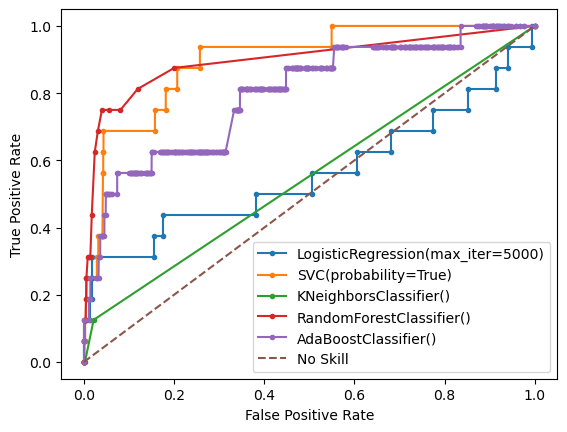

In [91]:
results_no_sample = []
models = [lr, svm, knn, rf, ada]
for m in models:
    m.fit(X_train, y_train.values.ravel())
    predicted = m.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    #prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    print(m, "\n", metrics.confusion_matrix(y_test,predicted), "\n")
    results_no_sample.append([acc, rec, f1, auc])

    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


In [151]:
results_no_sample

[[0.9960163710777626,
  0.07142857142857142,
  0.12048192771084336,
  0.5354951676644363],
 [0.9961800818553889, 0.0, 0.0, 0.5],
 [0.9960163710777626,
  0.17142857142857143,
  0.2474226804123711,
  0.5853034393708182],
 [0.996343792633015,
  0.04285714285714286,
  0.0821917808219178,
  0.5214285714285715],
 [0.9964529331514325,
  0.21428571428571427,
  0.3157894736842105,
  0.6068689595805453]]

In [92]:
X_train_np = np.expand_dims(X_train.values[:,:], axis=2)
y_train_np = y_train.values[:]
X_test_np = np.expand_dims(X_test.values[:,:],axis = 2)
y_test_np = y_test.values[:]
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(len(X.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['Accuracy'])
model.fit(X_train_np, y_train_np, epochs=5, batch_size=16, validation_data=(X_test_np, y_test_np))
X_np = np.expand_dims(X_test.values[:,:],axis = 2)
y_np = y_test.values[:]
ypred = model.predict(X_np)
predlabels = [int(p>=0.5) for p in ypred]
acc = metrics.accuracy_score(y_test, predlabels)
rec = metrics.recall_score(y_test, predlabels)
cf_matrix = metrics.confusion_matrix(y_test,predlabels)
print(cf_matrix)
print("LSTM Accuracy:", acc)
print("LSTM Recall:", rec)
results_no_sample.append([acc, rec])
cf_matrix = metrics.confusion_matrix(y_test,predlabels)
print(results_no_sample)

2023-04-25 20:59:26.007304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
507/507 [==============================] - 78s 148ms/step - loss: 0.0480 - Accuracy: 0.9922 - val_loss: 0.0312 - val_Accuracy: 0.9954
Epoch 2/5
507/507 [==============================] - 74s 146ms/step - loss: 0.0400 - Accuracy: 0.9936 - val_loss: 0.0296 - val_Accuracy: 0.9954
Epoch 3/5
507/507 [==============================] - 74s 145ms/step - loss: 0.0394 - Accuracy: 0.9936 - val_loss: 0.0296 - val_Accuracy: 0.9954
Epoch 4/5
507/507 [==============================] - 73s 144ms/step - loss: 0.0394 - Accuracy: 0.9936 - val_loss: 0.0296 - val_Accuracy: 0.9954
Epoch 5/5
109/109 [==============================] - 7s 57ms/step
[[3461    0]
 [  16    0]]
LSTM Accuracy: 0.995398331895312
LSTM Recall: 0.0
[[0.994535519125683, 0.0625, 0.09523809523809523, 0.530672132331696], [0.995398331895312, 0.0, 0.0, 0.5], [0.9951107276387691, 0.0, 0.0, 0.499855533082924], [0.995398331895312, 0.0, 0.0, 0.5], [0.9936727063560541, 0.125, 0.15384615384615385, 0.5613442646633922], [0.995398331895312

In [93]:
final_undersample = RandomUnderSampler(sampling_strategy='majority')
X_final_under, y_final_under = final_undersample.fit_resample(X_train, y_train)
final_under = X_final_under.copy()
final_under['label'] = y_final_under

final_oversample = RandomOverSampler(sampling_strategy='minority')
X_final_over, y_final_over = final_oversample.fit_resample(X_train, y_train)
final_over = X_final_over.copy()
final_over['label'] = y_final_over

final_smote = SMOTE(k_neighbors=10)
X_final_smote, y_final_smote = final_smote.fit_resample(X_train, y_train)
final_smote = X_final_smote.copy()
final_smote['label'] = y_final_smote

final_blsmote = BorderlineSMOTE(k_neighbors=10)
X_final_blsmote, y_final_blsmote = final_blsmote.fit_resample(X_train, y_train)
final_blsmote = X_final_blsmote.copy()
final_blsmote['label'] = y_final_blsmote

final_adasyn = ADASYN(n_neighbors=10)
X_final_adasyn, y_final_adasyn = final_adasyn.fit_resample(X_train, y_train)
final_adasyn = X_final_adasyn.copy()
final_adasyn['label'] = y_final_adasyn

# Undersampling

In [94]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_final_under, y_final_under, test_size=0.3)

In [95]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_under,y_train_under.values.ravel())
# print("LR best estimater: ", grid.best_estimator_)
# print("LR Best parameters:", grid.best_params_)
# under_lr_best_est = grid.best_estimator_


In [96]:

# #linear failed to converge 
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_under,y_train_under.values.ravel())
# print("SVM best estimater: ", grid.best_estimator_)
# print("SVM Best parameters:", grid.best_params_)
# under_svm_best_est = grid.best_estimator_



In [97]:

# param_grid = {'n_neighbors': list(range(1,21)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_under,y_train_under.values.ravel())
# print("KNN best estimater: ", grid.best_estimator_)
# print("KNN Best parameters:", grid.best_params_)
# under_knn_best_est = grid.best_estimator_


In [98]:

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_under, y_train_under.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# under_rf_best_est = grid.best_estimator_



In [99]:

# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_under, y_train_under.values.ravel())
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# under_ada_best_est = grid.best_estimator_


In [100]:
# #Adapt from above
# lr = LogisticRegression(max_iter=1000)
# svm = SVC(probability=True)
# knn = bls_knn_best_est
# rf = bls_rf_best_est
# ada = bls_ada_best_est


LogisticRegression(max_iter=5000) 
 [[2862  599]
 [   7    9]] 

SVC(probability=True) 
 [[3205  256]
 [   6   10]] 

KNeighborsClassifier() 
 [[3212  249]
 [  13    3]] 

RandomForestClassifier() 
 [[2784  677]
 [   3   13]] 

AdaBoostClassifier() 
 [[2483  978]
 [   6   10]] 



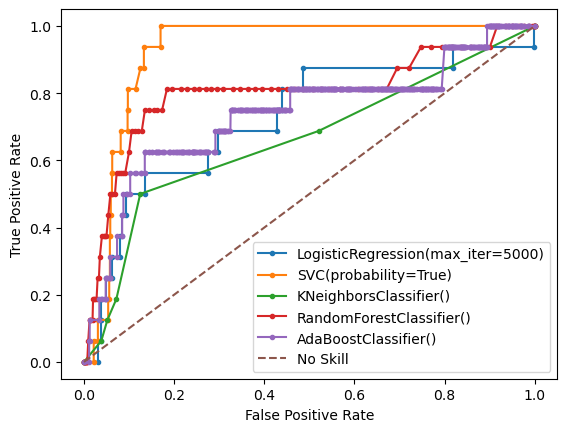

In [101]:
results_under = []
models = [lr, svm, knn, rf, ada]
for m in models:
    m.fit(X_train_under, y_train_under.values.ravel())
    predicted = m.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    print(m, "\n", metrics.confusion_matrix(y_test,predicted), "\n")
    results_under.append([acc, rec, prec, f1, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


In [ ]:

X_numpy_under = np.expand_dims(X_train_under.values[:,:],axis = 2)
y_numpy_under = y_train_under.values[:]
X_numpy_under_test = np.expand_dims(X_test_under.values[:,:],axis = 2)
y_numpy_under_test = y_test_under.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_under.append([acc, rec, prec, auc])

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()
predlabels = [int(p>=0.5) for p in ypred]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predlabels)

pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_under)



# Oversampling

In [102]:
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_final_over, y_final_over, test_size=0.3)


In [103]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_over,y_train_over.values.ravel())
# print("LR best estimater: ", grid.best_estimator_)
# print("LR Best parameters:", grid.best_params_)
# over_lr_best_est = grid.best_estimator_



In [104]:
# #linear failed to converge 
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_over,y_train_over.values.ravel())
# print("SVM best estimater: ", grid.best_estimator_)
# print("SVM Best parameters:", grid.best_params_)
# over_svm_best_est = grid.best_estimator_

In [105]:

# param_grid = {'n_neighbors': list(range(1,21)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_over,y_train_over.values.ravel())
# print("KNN best estimater: ", grid.best_estimator_)
# print("KNN Best parameters:", grid.best_params_)
# over_knn_best_est = grid.best_estimator_


In [106]:
# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_over, y_train_over.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# over_rf_best_est = grid.best_estimator_


In [107]:

# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_over, y_train_over.values.ravel())
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# over_ada_best_est = grid.best_estimator_


In [108]:
# #Adapt from above
lr = LogisticRegression(max_iter=1000)
svm = SVC(probability=True)
# knn = bls_knn_best_est
# rf = bls_rf_best_est
# ada = bls_ada_best_est

LogisticRegression(max_iter=1000) 
 [[3250  211]
 [  14    2]] 

SVC(probability=True) 
 [[3349  112]
 [  13    3]] 

KNeighborsClassifier() 
 [[3397   64]
 [  15    1]] 



/opt/anaconda3/envs/praxis1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier() 
 [[3461    0]
 [  16    0]] 

AdaBoostClassifier() 
 [[3242  219]
 [  11    5]] 



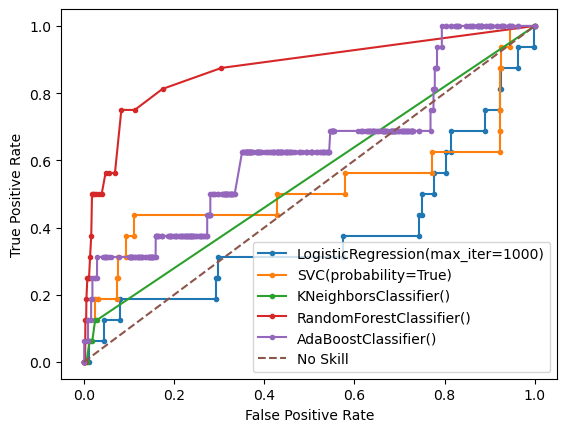

In [109]:
results_over = []
models = [lr, svm, knn, rf, ada]
for m in models:
    m.fit(X_train_over, y_train_over.values.ravel())
    predicted = m.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    #prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    print(m, "\n", metrics.confusion_matrix(y_test,predicted), "\n")
    results_over.append([acc, rec, prec, auc, f1])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


In [ ]:

X_numpy_over = np.expand_dims(X_train_over.values[:,:],axis = 2)
y_numpy_over = y_train_over.values[:]
X_numpy_over_test = np.expand_dims(X_test_over.values[:,:],axis = 2)
y_numpy_over_test = y_test_over.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()
results_over.append([acc, rec,])

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()
predlabels = [int(p>=0.5) for p in ypred]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predlabels)

pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_over)



In [ ]:
# #Adapt from above
lr = LogisticRegression(max_iter=1000)
svm = SVC(probability=True, kernel='rbf', C=1, gamma='auto')
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='manhattan')
# rf = bls_rf_best_est
# ada = bls_ada_best_est

/opt/anaconda3/envs/praxis1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
76/76 [==============================] - 9s 92ms/step - loss: 0.6210 - accuracy: 0.6707 - val_loss: 0.4893 - val_accuracy: 0.9022
Epoch 2/15
76/76 [==============================] - 7s 86ms/step - loss: 0.5917 - accuracy: 0.6795 - val_loss: 0.3532 - val_accuracy: 0.8615
Epoch 3/15
76/76 [==============================] - 6s 85ms/step - loss: 0.5903 - accuracy: 0.6789 - val_loss: 0.3902 - val_accuracy: 0.8547
Epoch 4/15
76/76 [==============================] - 7s 87ms/step - loss: 0.5857 - accuracy: 0.6836 - val_loss: 0.3964 - val_accuracy: 0.8802
Epoch 5/15
76/76 [==============================] - 7s 87ms/step - loss: 0.5835 - accuracy: 0.6872 - val_loss: 0.4744 - val_accuracy: 0.9011
Epoch 6/15
76/76 [==============================] - 6s 84ms/step - loss: 0.5769 - accuracy: 0.6985 - val_loss: 0.3978 - val_accuracy: 0.9418
Epoch 7/15
76/76 [==============================] - 6s 86ms/step - loss: 0.5655 - accuracy: 0.7091 - val_loss: 0.4445 - val_accuracy: 0.8387
Epoch 8/15
76

InvalidArgumentError: {{function_node __wrapped__Equal_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [3477] vs. [584136] [Op:Equal]

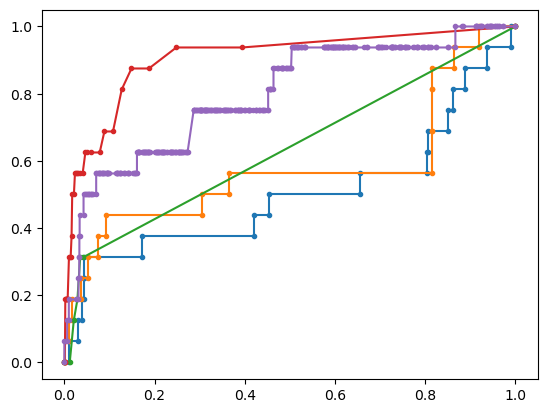

In [110]:
final_oversample_1 = RandomOverSampler(sampling_strategy=0.2)
X_final_over_1, y_final_over_1 = final_oversample_1.fit_resample(X_train, y_train)
final_undersample1 = RandomUnderSampler(sampling_strategy=.5)
X_final_over_under, y_final_over_under = final_undersample1.fit_resample(X_final_over_1, y_final_over_1)

results_over_under = []
models = [lr, svm, knn, rf, ada]
for m in models:
    m.fit(X_final_over_under, y_final_over_under.values.ravel())
    predicted = m.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    results_over_under.append([acc, rec, prec, auc, f1])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

X_numpy_over_under = np.expand_dims(X_final_over_under.values[:,:],axis = 2)
y_numpy_over_under = y_final_over_under.values[:]
X_numpy_over_under_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_over_under_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_over_under, y_numpy_over_under, epochs=15, batch_size=64, validation_data=(X_numpy_over_under_test, y_numpy_over_under_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()
results_over.append([acc, rec, prec, auc])

predlabels = [int(p>=0.5) for p in ypred]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predlabels)

pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_over)

# SMOTE

In [111]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_final_smote, y_final_smote, test_size=0.3)

In [112]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_smote,y_train_smote.values.ravel())
# print("logistic regression best: ", grid.best_estimator_)
# smote_lr_best_est = grid.best_estimator_



In [113]:
# #linear failed to converge
# param_grid = {'C': [1], 'gamma': ['auto'],'kernel': ['rbf']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_smote,y_train_smote.values.ravel())
# print("SVM best: ", grid.best_estimator_)
# smote_svm_best_est = grid.best_estimator_

In [114]:

# param_grid = {'n_neighbors': list(range(5,6)), 'metric': ['manhattan'], 'weights': ['uniform'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=2,cv=1, scoring='accuracy', return_train_score=False)
# grid.fit(X_train_smote,y_train_smote.values.ravel())
# print("KNN best: ", grid.best_estimator_)
# smote_knn_best_est = grid.best_estimator_

In [115]:

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=2,cv=5, scoring='recall', return_train_score=False)
# grid.fit(X_train_smote, y_train_smote.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# print("RF Best score:", grid.best_score_)
# smote_rf_best_est = grid.best_estimator_


In [116]:
# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_smote, y_train_smote.values.ravel())
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# print("ADA Best score:", grid.best_score_)
# smote_ada_best_est = grid.best_estimator_

In [117]:
# # #Adapt from above
# # lr = LogisticRegression(max_iter=1000)
# svm = SVC(probability=True)
# knn = smote_knn_best_est
# rf = smote_rf_best_est
# # ada = bls_ada_best_est

LogisticRegression(max_iter=1000) 
 [[3250  211]
 [  12    4]] 

SVC(probability=True) 
 [[3395   66]
 [  14    2]] 

KNeighborsClassifier() 
 [[3308  153]
 [   9    7]] 

RandomForestClassifier() 
 [[3213  248]
 [  13    3]] 

AdaBoostClassifier() 
 [[2321 1140]
 [   5   11]] 



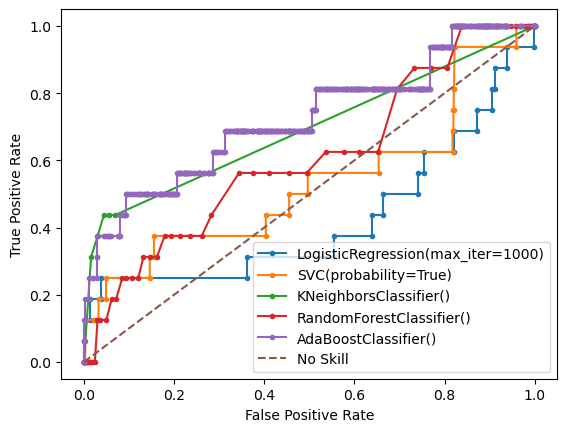

In [118]:
results_smote = []
models = [lr, svm, knn, rf, ada]

for m in models:
    m.fit(X_train_smote, y_train_smote.values.ravel())
    predicted = m.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    print(m, "\n", metrics.confusion_matrix(y_test,predicted), "\n")
    results_smote.append([acc, rec, prec, auc, f1])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:


X_numpy_smote = np.expand_dims(X_train_smote.values[:,:],axis = 2)
y_numpy_smote = y_train_smote.values[:]
X_numpy_smote_test = np.expand_dims(X_test_smote.values[:,:],axis = 2)
y_numpy_smote_test = y_test_smote.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_smote.append([acc, rec, prec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_smote)

# ADASYN

In [ ]:
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_final_adasyn, y_final_adasyn, test_size=0.3)

In [ ]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("logistic regression best: ", grid.best_estimator_)
# ada_lr_best_est = grid.best_estimator_



In [ ]:

# #linear failed to converge
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("SVM best: ", grid.best_estimator_)
# ada_svm_best_est = grid.best_estimator_



In [ ]:

# param_grid = {'n_neighbors': list(range(1,21)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("KNN best: ", grid.best_estimator_)
# ada_knn_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn, y_train_adasyn.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# print("RF Best score:", grid.best_score_)
# ada_rf_best_est = grid.best_estimator_


In [ ]:

# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn, y_train_adasyn.values.ravel())
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# print("ADA Best score:", grid.best_score_)
# ada_ada_best_est = grid.best_estimator_

In [ ]:
# #Adapt from above
# lr = ada_lr_best_est
# svm = ada_svm_best_est
# knn = ada_knn_best_est
# rf = ada_rf_best_est
# ada = ada_ada_best_est


In [ ]:
results_adasyn = []
models = [lr, svm, knn, rf, ada]

for m in models:
    m.fit(X_train_adasyn, y_train_adasyn.values.ravel())
    predicted = m.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    results_adasyn.append([acc, rec, prec, f1, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

X_numpy_adasyn = np.expand_dims(X_train_adasyn.values[:,:],axis = 2)
y_numpy_adasyn = y_train_adasyn.values[:]
X_numpy_adasyn_test = np.expand_dims(X_test_adasyn.values[:,:],axis = 2)
y_numpy_adasyn_test = y_test_adasyn.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_adasyn.append([acc, rec, prec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_adasyn)

# Borderline SMOTE

In [ ]:
X_train_blsmote, X_test_blsmote, y_train_blsmote, y_test_blsmote = train_test_split(X_final_blsmote, y_final_blsmote, test_size=0.3)

In [ ]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("logistic regression best: ", grid.best_estimator_)
# bls_lr_best_est = grid.best_estimator_



In [ ]:

# #linear failed to converge
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("SVM best: ", grid.best_estimator_)
# bls_svm_best_est = grid.best_estimator_

In [ ]:

# param_grid = {'n_neighbors': list(range(1,21)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("KNN best: ", grid.best_estimator_)
# bls_knn_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote, y_train_blsmote.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# print("RF Best score:", grid.best_score_)
# bls_rf_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote, y_train_blsmote)
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# print("ADA Best score:", grid.best_score_)
# bls_ada_best_est = grid.best_estimator_

In [ ]:
# #Adapt from above
# lr = LogisticRegression(max_iter=1000)
# svm = SVC(probability=True)
# knn = bls_knn_best_est
# rf = bls_rf_best_est
# ada = bls_ada_best_est

In [ ]:
results_blsmote = []
models = [lr, svm, knn, rf, ada]

for m in models:
    m.fit(X_train_blsmote, y_train_blsmote.values.ravel())
    predicted = m.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    results_blsmote.append([acc, rec, prec, f1, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

X_numpy_blsmote = np.expand_dims(X_train_blsmote.values[:,:],axis = 2)
y_numpy_blsmote = y_train_blsmote.values[:]
X_numpy_blsmote_test = np.expand_dims(X_test_blsmote.values[:,:],axis = 2)
y_numpy_blsmote_test = y_test_blsmote.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_blsmote.append([acc, rec, prec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_blsmote)

In [ ]:
final_results = [[results_no_sample], [results_under], [results_over], [results_smote], [results_adasyn], [results_blsmote]]

In [ ]:
final_results

In [ ]:
# sb.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
# mean0 = final_adasyn[final_adasyn['label'] == 0].sample(30)
# mean1 = final_adasyn[final_adasyn['label'] == 1].sample(30)
# fvalue, pvalue = stats.ttest_ind(mean0['text_distance'], mean1['text_distance'])
# print(fvalue, pvalue)

In [ ]:
# pca = PCA(n_components = 5)
# X_train_blsmote = pca.fit_transform(X_train_blsmote)
# X_test_blsmote = pca.transform(X_test_blsmote)
# explained_variance = pca.explained_variance_ratio_
# explained_variance